# Identifying shipping lanes with radar <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment only
* **Products used:** 
[s1_gamma0_geotif_scene](https://explorer.sandbox.dea.ga.gov.au/s1_gamma0_geotif_scene)

## Background
Being able to spot ships and shipping lanes from satellite imagery can be useful for gaining a holistic picture of maritime traffic.
The properties of radar data can be utilised to detect where ships appear over time, highlighting the presence of shipping lanes.

When working with radar data, water commonly appears dark; its relatively smooth surface results in very little backscatter, and consequently, low intensities are recorded by the satellite in both polarisation bands. 
However, if a large ship is on the water, the backscatter at the ship's location will be much higher than the water.

This notebook was inspired by [this thread](https://twitter.com/sgascoin/status/1113184052587171842) on Twitter.

### Sentinel-1 use case
The ESA/EC Copernicus Sentinel-1 mission has been operating since April 2014. 
The two satellites (Sentinel-1A and 1B) have a frequent revisit time of 6 days.
This helps to build a large catalogue of observations that can be leveraged to identify shipping lanes.

## Description
In this example, we attempt to identify shipping lanes around Australia by taking advantage of the fact that ships on the water result in a large radar backscatter signal.
This can be done by finding the maximum of each pixel in Sentinel-1 images.
Computing the maximum value for many pixels is computationally expensive, so we make use of the parallel-computing library [Dask](https://docs.dask.org/en/latest/).
The worked example takes user through the code required to

1. Load Sentinel-1 backscatter data for an area of interest.
2. Calculate the maximum value for each pixel using Dask.
3. Visualise the maximum values to identify shipping lanes.

***

## Getting started

**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, return to the "Analysis parameters" cell, modify some values (e.g. choose a different location or time period to analyse) and re-run the analysis.
There are additional instructions on modifying the notebook at the end.

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import dask
import datacube
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.dask import create_local_dask_cluster
from dea_tools.plotting import display_map


/env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [2]:
dc = datacube.Datacube(app="Shipping_lane_identification")

### Set up distributed computing
Calculating the maximum value for each pixel in an image can be computationally expensive.
However, it is possible to reduce the computation time by parallelising the process through Dask.
Access to Dask is provided as part of the DEA environment.

To set up distributed computing with Dask, you need to first set up a Dask client using the function below:

> **Note:** For more information about using Dask, refer to the [Parallel processing with Dask](07_Parallel_processing_with_Dask.ipynb) notebook.

In [3]:
create_local_dask_cluster()

/env/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35131 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:38693 Dashboard: /user/robbibt/proxy/35131/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB


### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.
The parameters are

* `latitude`: The latitude range to analyse (e.g. `(-41.277, -40.977)`).
For reasonable loading times, make sure the range spans less than ~0.1 degrees.
* `longitude`: The longitude range to analyse (e.g. `(146.145, 146.545)`).
For reasonable loading times, make sure the range spans less than ~0.1 degrees.
* `time`: The date range to analyse (e.g. `('2017-01-01', '2018-01-01')`).

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers Devonport, Tasmania, which is where the Spirit of Tasmania (the ferry between Melbourne and Tasmania) transits from.

**To run the notebook for a different area**, make sure Sentinel-1 data is available for the chosen area using the [DEA Sandbox Explorer](https://explorer.sandbox.dea.ga.gov.au/s1_gamma0_geotif_scene).
We provide a list of additional ports to try at the end of this notebook.


In [4]:
# Define the area of interest
latitude = (-41.277, -40.977)
longitude = (146.145, 146.545)

# Set the range of dates for the analysis
time = ("2017-01-01", "2018-01-01")

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [5]:
display_map(x=longitude, y=latitude)

## Load and view Sentinel-1 data

The first step in the analysis is to load Sentinel-1 backscatter data for the specified area of interest.
As part of specifying the load, the `dask_chunks` argument is used to tell Dask how to segement the data for parallelised computations (see the [xarray documentation](http://xarray.pydata.org/en/stable/dask.html)). 

In [6]:
ds = dc.load(
    product="s1_gamma0_geotif_scene",
    x=longitude,
    y=latitude,
    output_crs="epsg:3577",
    resolution=(-25, 25),
    time=time,
    dask_chunks={"x": 4000, "y": 4000, "time": 1}
)

ds

<xarray.Dataset>
Dimensions:      (time: 115, x: 1511, y: 1452)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-01T19:25:41.446675 ... 2017-12...
  * y            (y) float64 -4.548e+06 -4.548e+06 ... -4.584e+06 -4.584e+06
  * x            (x) float64 1.209e+06 1.209e+06 ... 1.246e+06 1.246e+06
    spatial_ref  int32 3577
Data variables:
    vh           (time, y, x) float32 dask.array<chunksize=(1, 1452, 1511), meta=np.ndarray>
    vv           (time, y, x) float32 dask.array<chunksize=(1, 1452, 1511), meta=np.ndarray>
Attributes:
    crs:           epsg:3577
    grid_mapping:  spatial_ref

### Visualise loaded data

Sentinel-1 backscatter data has two measurements, *VV* and *VH*, which correspond to the polarisation of the light sent and received by the satellite.
*VV* refers to the satellite sending out vertically-polarised light and receiving vertically-polarised light back, whereas *VH* refers to the satellite sending out vertically-polarised light and receiving horizontally-polarised light back.
These two measurement bands can tell us different information about the area we're studying. 

When working with radar backscatter, it is common to work with the data in units of decibels (dB), rather than digital number (DN) as measured by the satellite.
To convert from DN to dB, we use the following formula:

$$
\begin{aligned}
\text{dB} = 10 \times \log_{10}(\text{DN}).
\end{aligned}
$$

The code below visualises the *VH* band for the first timestep in the dataset:

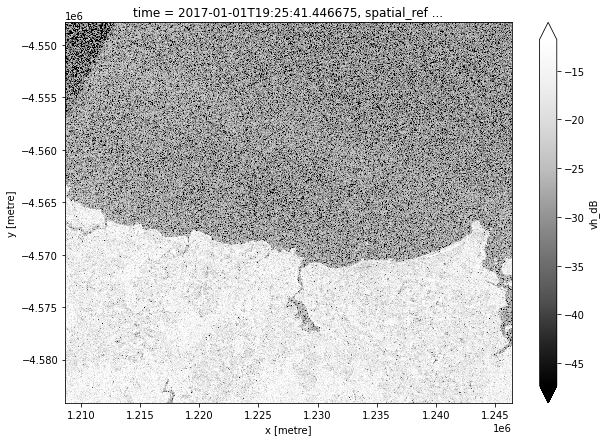

In [7]:
# Scale to plot data in decibels
ds["vh_dB"] = 10 * np.log10(ds.vh)

# Plot all VH observations for the year
ds.vh_dB.isel(time=0).plot(cmap="Greys_r", robust=True, figsize=(10,7))
plt.show()

## Calculating and plotting the maximum pixel value

After loading the data, we can calculate the maximum value for each pixel measured in decibels.
Note that the Dask operation will occur when attempting to plot the `vh_dB` band in the cell below.
To see the computational resources being used when you run the operation, visit https://dask.sandbox.dea.ga.gov.au/status.

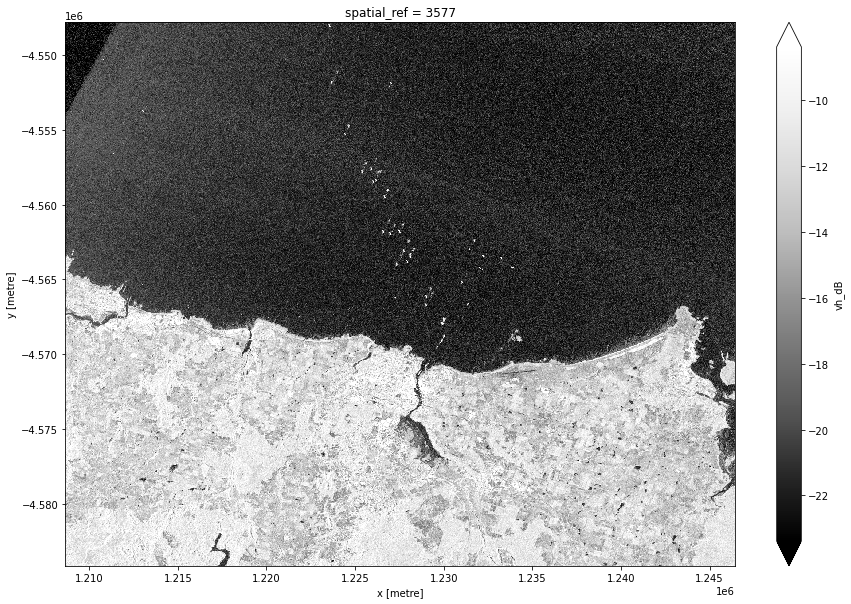

In [8]:
max_vh = ds.vh_dB.max(dim="time")

max_vh.plot.imshow(size=10, cmap="Greys_r", robust=True)
plt.show()

## Conclusion

The high contrast between the ships and the water can make for striking images.
Fortunately, processing with Dask makes it possible to make these computationally-intensive images in under a minute, even for very large areas.

Only a year of data is available at the moment, but more observations would likely lead to clearer identification of the shipping lanes.

## Next steps

When you are done, return to the "Set up analysis" cell, modify some values (e.g. `latitude` and `longitude`) and rerun the analysis.

There are a number of key ports covered by DEA Sentinel-1 data. 
The available data can be viewed on the [DEA Explorer](https://explorer.sandbox.dea.ga.gov.au/s1_gamma0_geotif_scene), but we also list the latitude and longitude coordinates for a few key ports below.

### New South Wales
**Port of Newcastle**

This is one of Australia's largest ports, with a diverse range of cargo types. 

```
latitude = (-33.128, -32.728)
longitude = (151.582, 151.982)
```

**Port Kembla**

This is the home to New South Wales' largest motor vehicle import hub and grain export terminal.

```
latitude = (-34.685, -34.285)
longitude = (150.699, 151.099)
```

**Port Jackson**

This includes Sydney Harbour, which houses numerous cruise ships and ferries. 

```
latitude = (-34.046, -33.646)
longitude = (151.049, 151.449)
```

### Northern Territory

**Port Darwin**

This is a key port in Darwin, covering livestock, containers, and cruise ships.

```
latitude = (-12.617, -12.217)
longitude = (130.600, 131.000)
```


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2021

**Compatible datacube version:** 

In [9]:
print(datacube.__version__)

1.8.5


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)